# Edge Detection from Scratch

Gradient magnitude: \( G[i] = \sqrt{G_x[i]^2 + G_y[i]^2} \)  
Using Sobel kernels for horizontal and vertical gradients.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Sobel kernels (3x3)

- **G_x**: horizontal gradient (vertical edges)
- **G_y**: vertical gradient (horizontal edges)

In [2]:
SOBEL_X = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float64)

SOBEL_Y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=np.float64)

## 2D convolution (no library edge detection)

Convolve image with a 3x3 kernel; output has same shape as input (valid-style then padded, or we use 'same' by shifting).

In [3]:
def convolve2d(image, kernel):
    """
    Same-mode 2D convolution. Output shape = input shape.
    """
    H, W = image.shape
    kh, kw = kernel.shape
    ph, pw = kh // 2, kw // 2
    # Pad image so output is same size
    padded = np.pad(image, ((ph, ph), (pw, pw)), mode='edge')
    out = np.zeros_like(image, dtype=np.float64)
    for i in range(H):
        for j in range(W):
            out[i, j] = np.sum(padded[i : i + kh, j : j + kw] * kernel)
    return out

In [4]:
def convolve2d_fast(image, kernel):
    """
    Same-mode 2D convolution using sliding-window view (faster, still no cv2).
    """
    H, W = image.shape
    kh, kw = kernel.shape
    ph, pw = kh // 2, kw // 2
    padded = np.pad(image, ((ph, ph), (pw, pw)), mode='edge')
    # Build sliding windows: (H, W, kh, kw)
    from numpy.lib.stride_tricks import sliding_window_view
    windows = sliding_window_view(padded, (kh, kw))
    # (H, W, kh, kw) * (kh, kw) -> sum over last two axes
    out = np.tensordot(windows, kernel, axes=((-2, -1), (0, 1)))
    return out.astype(np.float64)

## Edge magnitude: \( G = \sqrt{G_x^2 + G_y^2} \)

In [5]:
def edge_magnitude(gx, gy):
    """
    Gradient magnitude: G[i] = sqrt(G_x[i]^2 + G_y[i]^2)
    """
    return np.sqrt(gx.astype(np.float64)**2 + gy.astype(np.float64)**2)

In [6]:
def detect_edges(image_2d, use_fast_convolve=True):
    """
    Detect edges using Sobel gradients and magnitude.
    image_2d: grayscale 2D array (H, W).
    """
    conv = convolve2d_fast if use_fast_convolve else convolve2d
    gx = conv(image_2d, SOBEL_X)
    gy = conv(image_2d, SOBEL_Y)
    magnitude = edge_magnitude(gx, gy)
    return magnitude, gx, gy

## Load image and convert to grayscale (manual)

In [7]:
def load_grayscale(path):
    img = Image.open(path).convert('RGB')
    arr = np.array(img)
    # Standard luminance: 0.299*R + 0.587*G + 0.114*B
    gray = 0.299 * arr[:, :, 0] + 0.587 * arr[:, :, 1] + 0.114 * arr[:, :, 2]
    return gray.astype(np.float64)

## Test on sample image

Use a built-in pattern if no file is present.

In [8]:
def make_test_image(size=256):
    """Create a simple test image with clear edges (circle + rectangle)."""
    y = np.linspace(-1, 1, size)
    x = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(x, y)
    circle = (xx**2 + yy**2 < 0.5**2).astype(np.float64) * 255
    rect = np.zeros((size, size), dtype=np.float64)
    a, b = size // 4, 3 * size // 4
    rect[a:b, a:b] = 180
    gray = np.clip(circle * 0.6 + rect * 0.4 + np.random.rand(size, size) * 20, 0, 255)
    return gray

In [9]:
import os

test_path = '/Users/palmerov/Downloads/input.pgm'
if os.path.isfile(test_path):
    gray = load_grayscale(test_path)
    print(f'Loaded {test_path}: shape {gray.shape}')
else:
    gray = make_test_image(256)
    print('Using synthetic test image (256x256)')

magnitude, gx, gy = detect_edges(gray)

Loaded /Users/palmerov/Downloads/input.pgm: shape (256, 256)


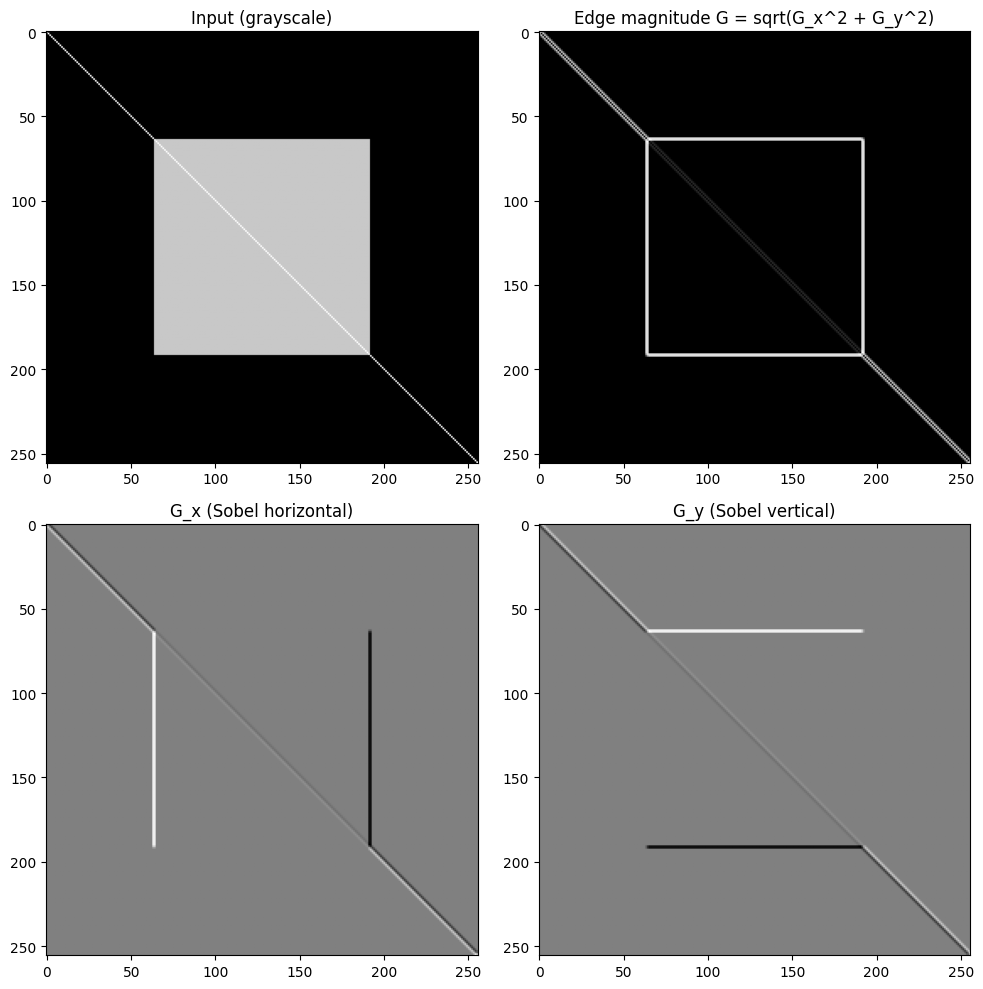

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(gray, cmap='gray')
axes[0, 0].set_title('Input (grayscale)')
axes[0, 1].imshow(magnitude, cmap='gray')
axes[0, 1].set_title('Edge magnitude G = sqrt(G_x^2 + G_y^2)')
axes[1, 0].imshow(gx, cmap='gray')
axes[1, 0].set_title('G_x (Sobel horizontal)')
axes[1, 1].imshow(gy, cmap='gray')
axes[1, 1].set_title('G_y (Sobel vertical)')
plt.tight_layout()
plt.show()

## Optional: normalize magnitude for display (0–255)

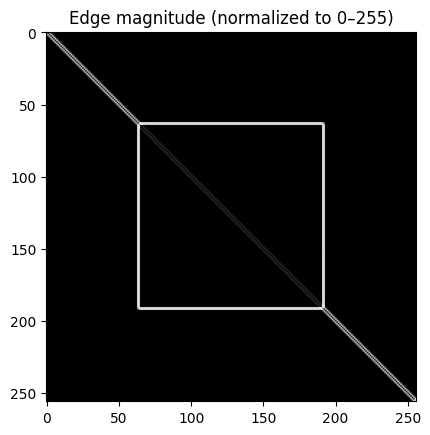

In [11]:
def normalize_uint8(mag):
    m_min, m_max = mag.min(), mag.max()
    if m_max > m_min:
        out = (255.0 * (mag - m_min) / (m_max - m_min)).astype(np.uint8)
    else:
        out = np.zeros_like(mag, dtype=np.uint8)
    return out

mag_display = normalize_uint8(magnitude)
plt.imshow(mag_display, cmap='gray')
plt.title('Edge magnitude (normalized to 0–255)')
plt.show()